In [1]:
import os
os.chdir('../../')

In [2]:
cd = os.getcwd()
functions_path = os.path.join(cd, '02_code/functions')

In [9]:
#import required packages

import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from anndata import AnnData

import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

# from scipy.sparse import csr_matrix
import sys
sys.path.append(functions_path)
import functions_dat_processing as dp

/tmp/ipykernel_2629535/552139305.py:19: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [11]:
import skmisc

In [24]:
#install required bioconductor and github packages
bioc = ro.packages.importr('BiocManager') 
remotes = ro.packages.importr('remotes')
utils = ro.packages.importr('utils')
utils.chooseCRANmirror(ind=1)

bioc.install('scran')
bioc.install('BiocParallel')
bioc.install('scry')

remotes.install_github('carmonalab/STACAS') #for integration based on MNNs
bioc.install('UCell')
utils.install_packages('scGate')#for celltype annotation

* installing *source* package ‘UCell’ ...
** using staged installation
** R
** data
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (UCell)


Update all/some/none? [a/s/n]: 

* installing *source* package ‘curl’ ...
** Paket ‘curl’ erfolgreich entpackt und MD5 Summen überprüft
** using staged installation


Found pkg-config cflags and libs!
Using PKG_CFLAGS=-I/usr/include/x86_64-linux-gnu
Using PKG_LIBS=-lcurl
--------------------------- [ANTICONF] --------------------------------
Configuration failed because libcurl was not found. Try installing:
 * deb: libcurl4-openssl-dev (Debian, Ubuntu, etc)
 * rpm: libcurl-devel (Fedora, CentOS, RHEL)
If libcurl is already installed, check that 'pkg-config' is in your
PATH and PKG_CONFIG_PATH contains a libcurl.pc file. If pkg-config
is unavailable you can set INCLUDE_DIR and LIB_DIR manually via:
R CMD INSTALL --configure-vars='INCLUDE_DIR=... LIB_DIR=...'
-------------------------- [ERROR MESSAGE] ---------------------------
In file included from /home/s377963/mambaforge/envs/scanpy/x86_64-conda-linux-gnu/sysroot/usr/include/features.h:375,
                 from /usr/include/x86_64-linux-gnu/sys/types.h:25,
                 from /usr/include/x86_64-linux-gnu/curl/system.h:430,
                 from /usr/include/x86_64-linux-gnu/curl/curl.h:35,
  

ERROR: configuration failed for package ‘curl’
* removing ‘/home/s377963/mambaforge/envs/scanpy/lib/R/library/curl’
* restoring previous ‘/home/s377963/mambaforge/envs/scanpy/lib/R/library/curl’
ERROR: failed to lock directory ‘/home/s377963/mambaforge/envs/scanpy/lib/R/library’ for modifying
Try removing ‘/home/s377963/mambaforge/envs/scanpy/lib/R/library/00LOCK-data.table’
ERROR: failed to lock directory ‘/home/s377963/mambaforge/envs/scanpy/lib/R/library’ for modifying
Try removing ‘/home/s377963/mambaforge/envs/scanpy/lib/R/library/00LOCK-igraph’
ERROR: failed to lock directory ‘/home/s377963/mambaforge/envs/scanpy/lib/R/library’ for modifying
Try removing ‘/home/s377963/mambaforge/envs/scanpy/lib/R/library/00LOCK-matrixStats’
* installing *source* package ‘rstudioapi’ ...
** Paket ‘rstudioapi’ erfolgreich entpackt und MD5 Summen überprüft
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying f

x86_64-conda-linux-gnu-cc -I"/home/s377963/mambaforge/envs/scanpy/lib/R/include" -DNDEBUG -I../inst/include/  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/s377963/mambaforge/envs/scanpy/include -I/home/s377963/mambaforge/envs/scanpy/include -Wl,-rpath-link,/home/s377963/mambaforge/envs/scanpy/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/s377963/mambaforge/envs/scanpy/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1723488709275/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/home/s377963/mambaforge/envs/scanpy=/usr/local/src/conda-prefix  -c bbox-handler.c -o bbox-handler.o
x86_64-conda-linux-gnu-cc -I"/home/s377963/mambaforge/envs/scanpy/lib/R/include" -DNDEBUG -I../inst/include/  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/s377963/mambaforge/envs/scanpy/include -I/home/s377963/mambaforge/envs/scanpy/include -Wl,-rpath-link,/home/s377

installing to /home/s377963/mambaforge/envs/scanpy/lib/R/library/00LOCK-wk/00new/wk/libs
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (wk)
ERROR: failed to lock directory ‘/home/s377963/mambaforge/envs/scanpy/lib/R/library’ for modifying
Try removing ‘/home/s377963/mambaforge/envs/scanpy/lib/R/library/00LOCK-spatstat.random’
ERROR: failed to lock directory ‘/home/s377963/mambaforge/envs/scanpy/lib/R/library’ for modifying
Try removing ‘/home/s377963/mambaforge/envs/scanpy/lib/R/library/00LOCK-spatstat.explore’
* installing *source* package ‘scGate’ ...
** Paket ‘scGate’ erfolgr

<rpy2.rinterface_lib.sexp.NULLType object at 0x7f1dc1503890> [0]

In [12]:
#import required R packages
soupx = ro.packages.importr('SoupX') 
scran = ro.packages.importr('scran') 
bcp = ro.packages.importr('BiocParallel') 
scry = ro.packages.importr('scry')
stacas = ro.packages.importr('STACAS')
seurat = ro.packages.importr('Seurat')
scgate = ro.packages.importr('scGate')
Matrix = ro.packages.importr('Matrix')


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

### 1. Import all the data

In [13]:
path_to_folders = './01_data/raw/cellranger_multi'
path_to_count_matrices_in_folders = 'per_sample_outs/count/sample_filtered_feature_bc_matrix'
path_to_raw_count_matrices_in_folders = 'count/raw_feature_bc_matrix'

adatas = dp.read_all_pools(path_to_folders, path_to_count_matrices_in_folders)
adatas_raw = dp.read_all_pools(path_to_folders, path_to_raw_count_matrices_in_folders)

Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P1_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P2_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P3_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P4_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P5_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P6_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P7_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellra

### 2. Transfer HTOs from count to obs column to avoid influence on SoupX and quality control

In [14]:
adatas, adatas_raw, conditions = dp.transfer_htos(adatas, adatas_raw)

### 3. perform quality control

In [15]:
# adatas_mad = dp.quality_control(adatas)
# adatas_qc = dp.quality_control(adatas)
# adatas_qc = dp.quality_control(adatas, method = 'qntl')
adatas_qc = dp.quality_control(adatas, method = 'abs')

computing qc for Pool 1
computing qc for Pool 2
computing qc for Pool 3
computing qc for Pool 4
computing qc for Pool 5
computing qc for Pool 6
computing qc for Pool 7
computing qc for Pool 8
computing qc for Pool 9


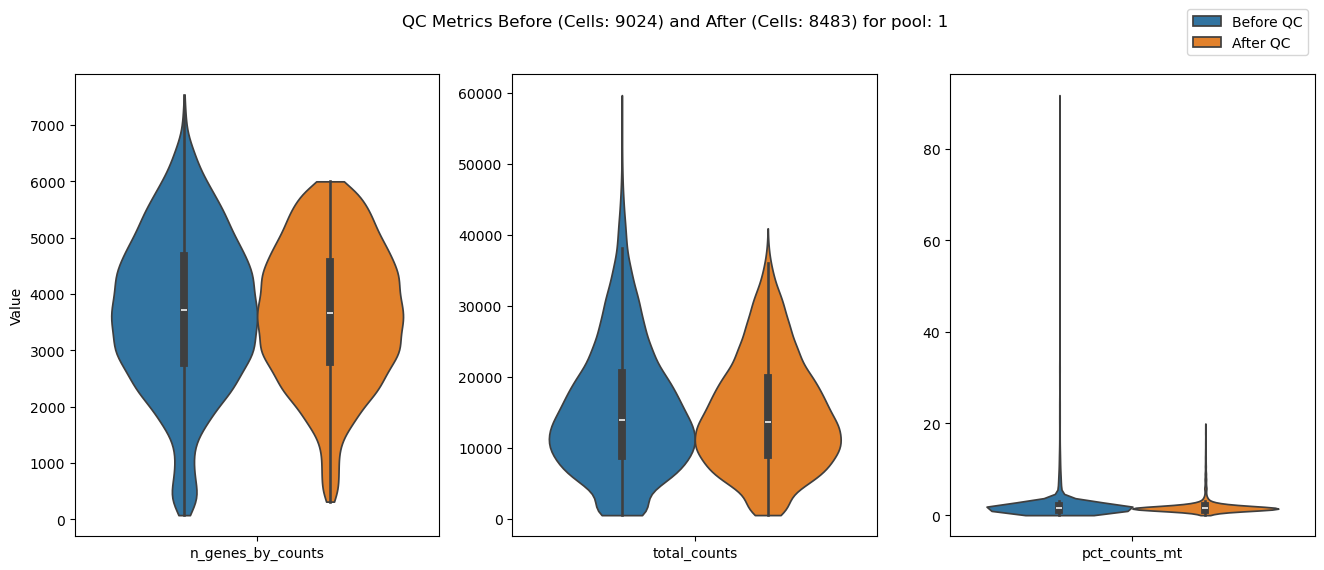

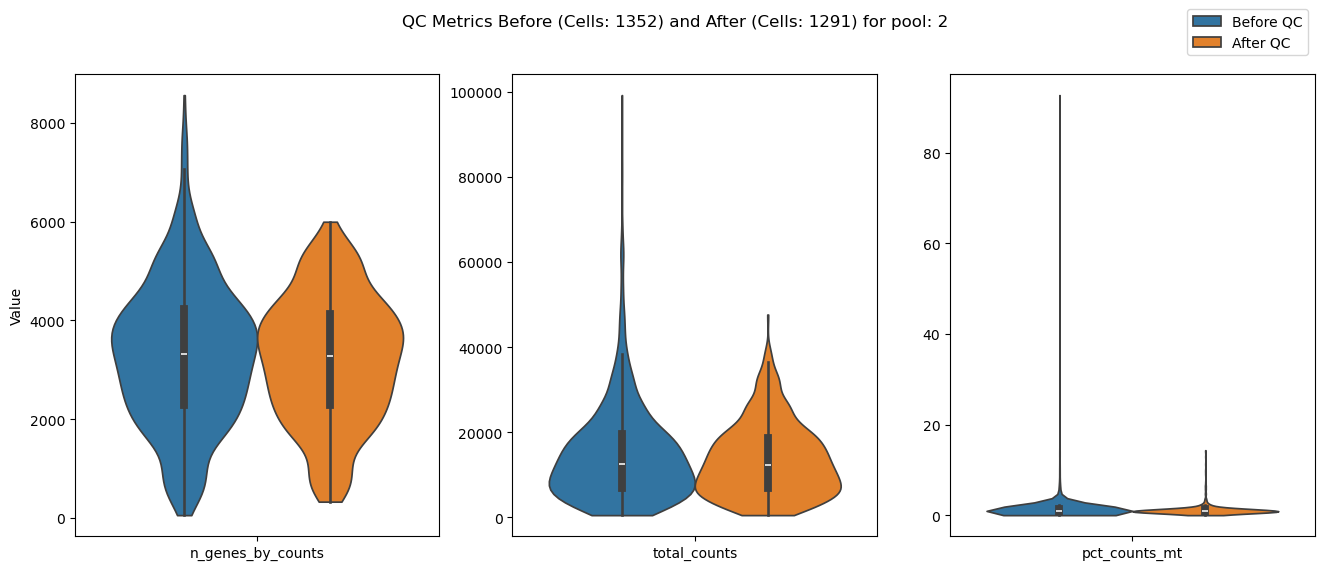

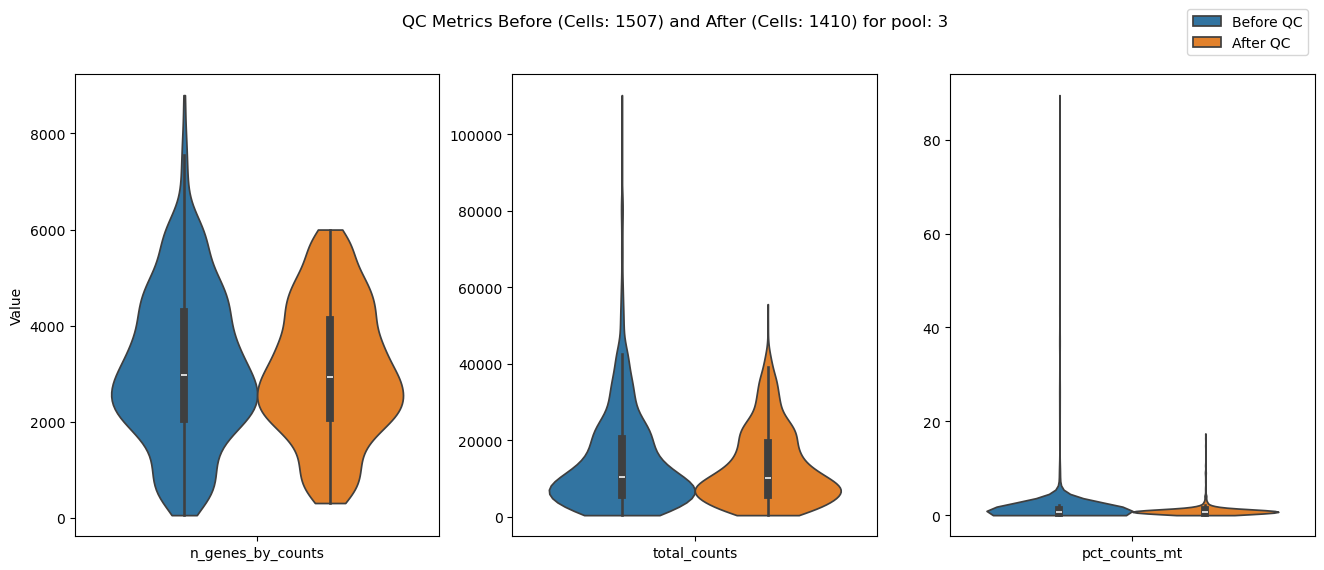

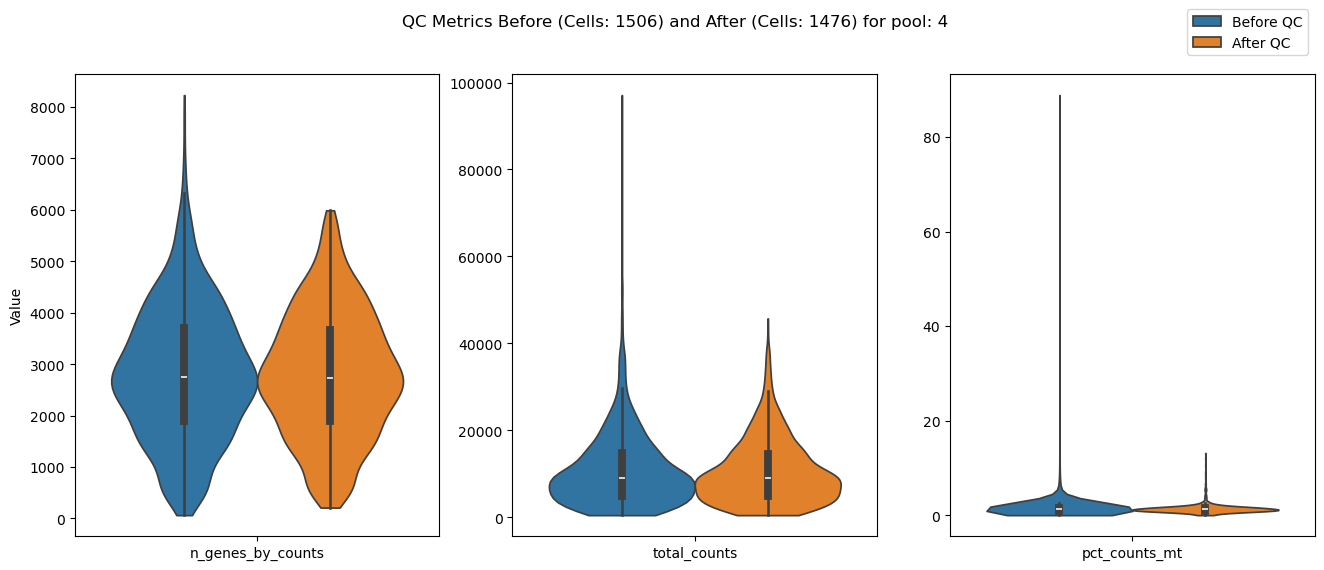

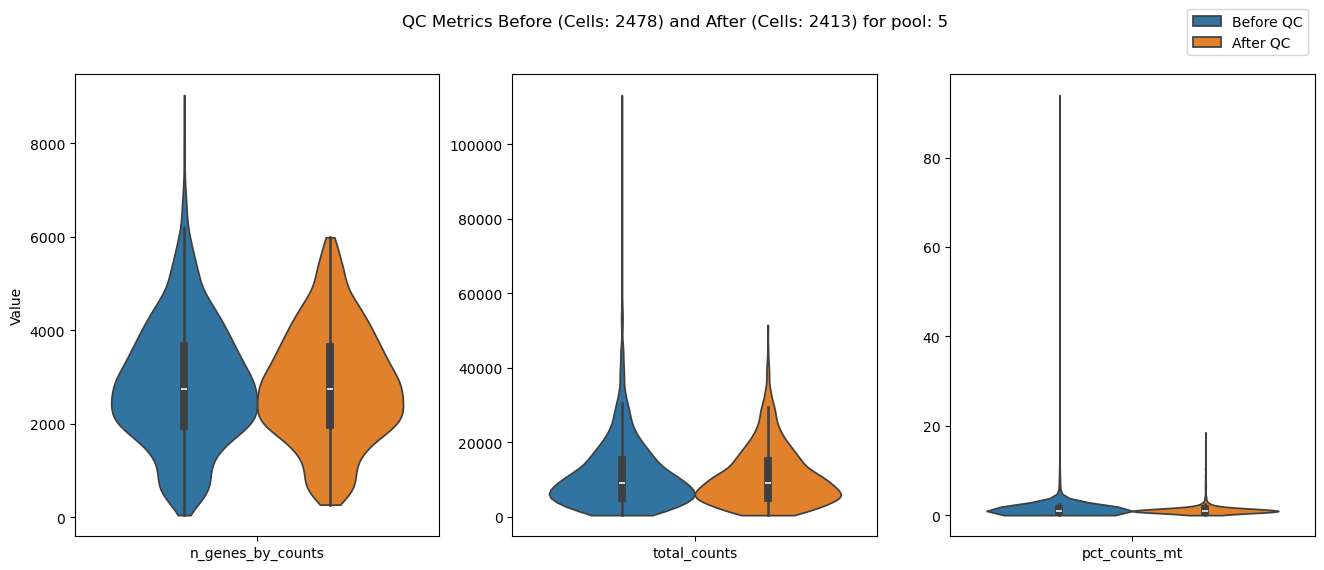

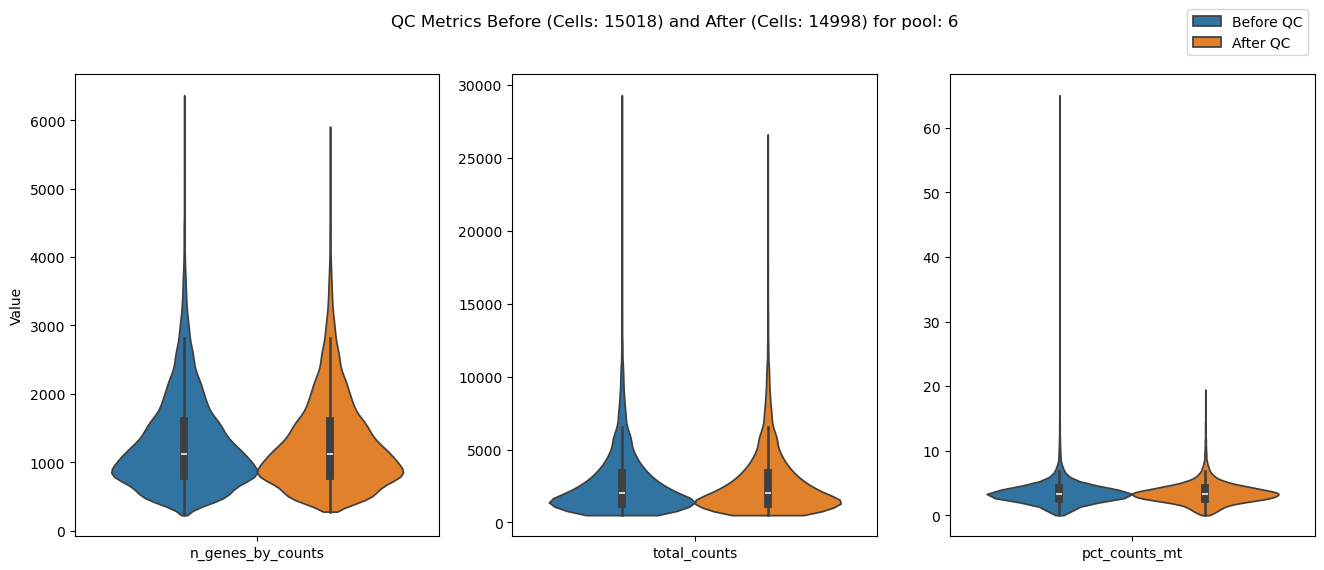

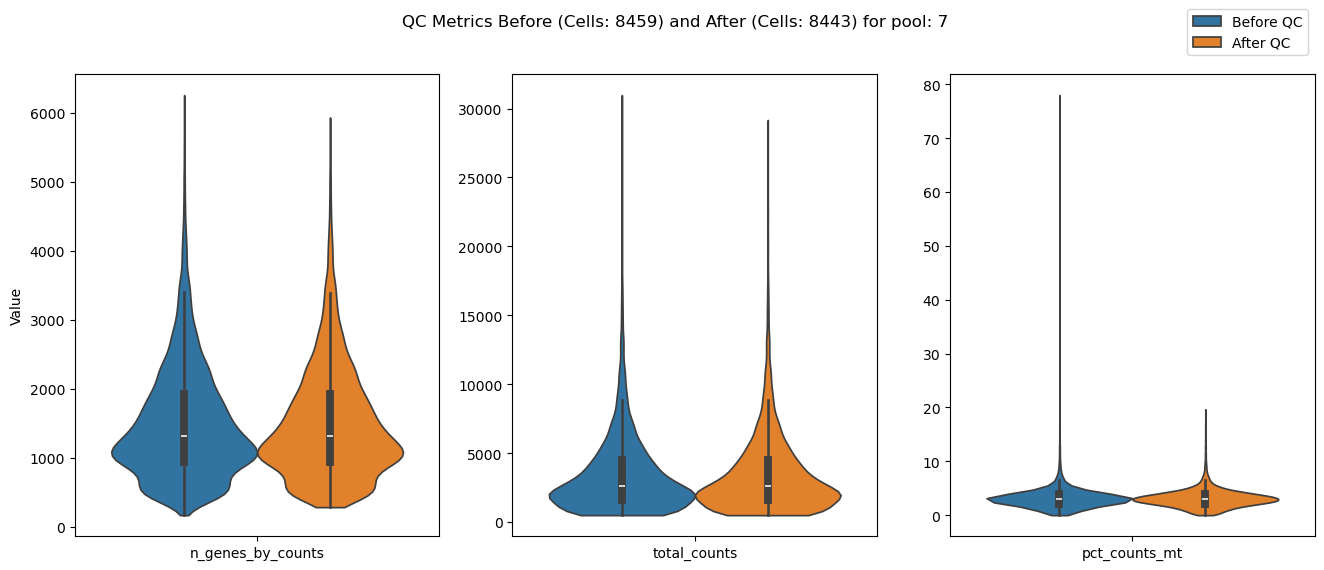

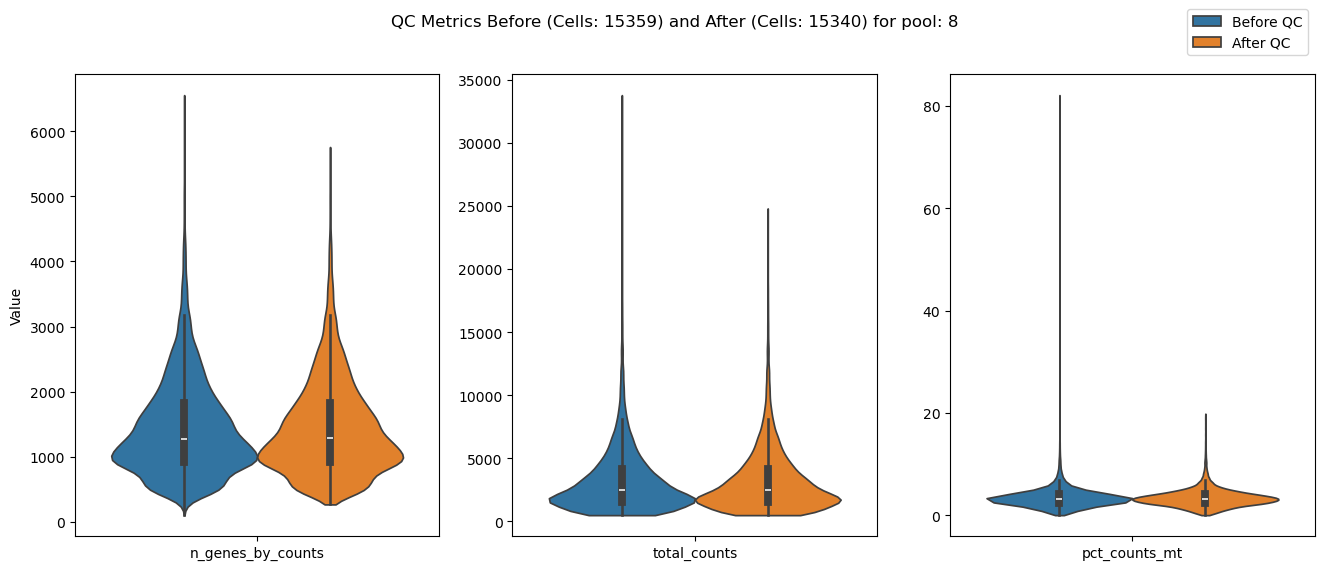

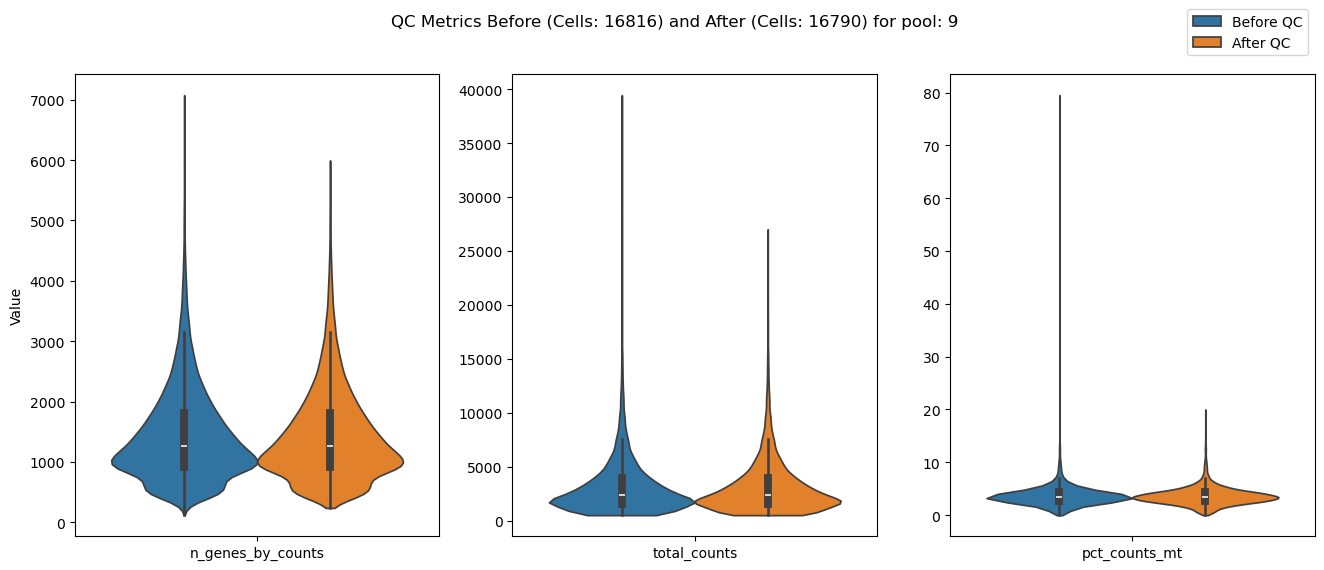

In [33]:
dp.plot_qc_metrics(adatas, adatas_qc)

In [16]:
adatas = adatas_qc

### 4. Perform SoupX to correct for ambient mRNA

In [35]:
groups = [dp.pregroup(adata) for adata in adatas]
adatas = [dp.cook_soup(adata, adata_raw, group) for (adata, adata_raw, group) in zip(adatas, adatas_raw, groups)]

### 5. Demultiplex the data using hashsolo (needs to be after qc since its based on priot probabilities that assume cells have passed filtering. Also, reasonable after SoupX, since filtering out doublets etc. will affect the soupx clusters)

In [17]:
dp.demultiplex(adatas, conditions)
adatas = [dp.filter_for_singlets(adata) for adata in adatas]

Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


### 6. Concatenate/merge all the pools

In [18]:
#merge andata objects, do not include genes that are not present in all samples (join = 'inner'), set to join = 'outer' if wanting to retain all genes if present in at least one dataset
adata_merged = ad.concat(adatas, join='inner', label='dataset',index_unique='_')

#since there are only about 200 dlN cells anyhow, filter them out 
adata_merged = adata_merged[ adata_merged.obs['Classification'].str.contains('d0')| adata_merged.obs['Classification'].str.contains('TIL')].copy()

### 7. Normalize the data using shifter logarithm or scran normalization

In [19]:
scales_counts = sc.pp.normalize_total(adata_merged, target_sum=1e4, inplace=False)
adata_merged.layers['log1p'] = sc.pp.log1p(scales_counts["X"], copy=True)

In [39]:
groups = dp.pregroup(adata_merged, resolution=15)
adata_merged.layers['scran'] = dp.scran_norm(adata_merged, groups)

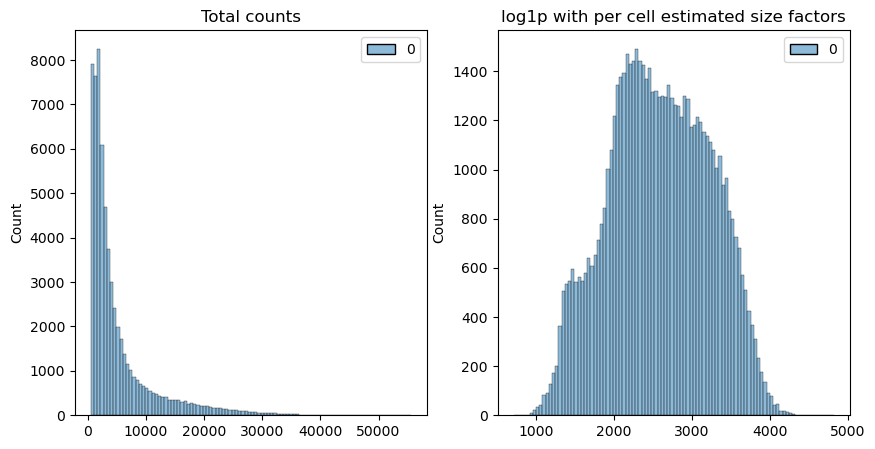

In [12]:
dp.plot_normalization(adata_merged, 'log1p', 'per cell')
# dp.plot_normalization(adata_merged, 'scran', 'scran')

In [20]:
#since scran does not really effectively normalize, we use the shifted logarithm
adata_merged.layers['counts'] = adata_merged.X
adata_merged.X = adata_merged.layers['log1p']

### 8. Perform feature selection

In [56]:
#select only the 2000 most variable genes in a batch aware way (meaning first in each batch 2000 most variable genes are selected and the 2000 genes that are variable in the most datasets are retained)
sc.pp.highly_variable_genes(adata_merged, n_top_genes=1000, flavor="seurat", batch_key='dataset')

#subset merged data based on highly variable genes 
adata_merged_hvg = adata_merged[:, adata_merged.var.highly_variable]

#store the genes selected by the hvg function for later use during integration
anchor_list = adata_merged_hvg.var_names.values

######
#alternatively with seurat, this yields about 60% the same genes, so its slightly different in selecting variale features, however the end result is extremely similar:
######
# %R seurat_features <- SelectIntegrationFeatures(batch_list, nfeatures=1000, fvf.nfeatures = 1000)
# %R -o seurat_features
# sum([scanpy_gene in anchor_list for scanpy_gene in seurat_features])

In [15]:
#plot the unintegrated data with coloring the discrete datasets to see their difference
sc.tl.pca(adata_merged_hvg, mask_var=None)
sc.pp.neighbors(adata_merged_hvg)
sc.tl.umap(adata_merged_hvg)
sc.tl.leiden(adata_merged_hvg, resolution=0.4, flavor="igraph" , n_iterations=2)

/home/s377963/mambaforge/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


AnnData object with n_obs × n_vars = 63474 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'dataset', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log1p'
    obsp: 'distances', 'connectivities'

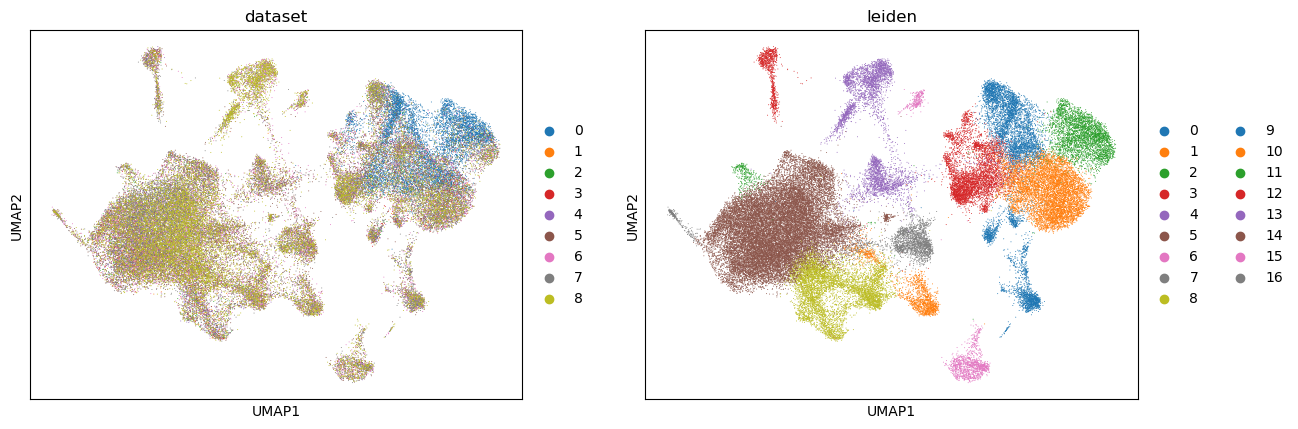

In [108]:
sc.pl.umap(adata_merged_hvg, color=['dataset', 'leiden'])

### 9. Perform data integration using Mutual Nearest Neighbots (since this is a way to effectively change the count matrix and unlike other integration methods, this yields not only a lower dimensional representation of the data)

In [18]:
import importlib
importlib.reload(dp)

<module 'functions_dat_processing' from '/home/s377963/car_t_sc/02_code/functions/functions_dat_processing.py'>

In [53]:
#STACAS uses normalized counts, in seurats tutoral, they first do NormalizeData() and use seurat integration afterwards
adata_merged_seurat = adata_merged.copy()
adata_merged_seurat.obs['dataset'] = adata_merged_seurat.obs['dataset'].astype(str)
del adata_merged_seurat.uns
ro.globalenv["adata_merged_seurat"] = adata_merged_seurat
ro.globalenv["anchor_list"] = anchor_list

%R seurat <- as.Seurat(adata_merged_seurat, counts = "counts", data = "log1p")
%R seurat <- RenameAssays(seurat, originalexp = "RNA")
%R batch_list <- SplitObject(seurat, split.by = "dataset")
%R integrated <-  Run.STACAS(batch_list, anchor.features = anchor_list, dims = 1:30) #rownames(seurat), 1000, anchor_list

%R integrated_expr <- GetAssayData(integrated)
%R integrated_expr <- t(integrated_expr)
%R -o integrated_expr

  |                                                  | 0 % ~calculating   |++++++                                            | 11% ~30s           |++++++++++++                                      | 22% ~14s           |+++++++++++++++++                                 | 33% ~08s           |+++++++++++++++++++++++                           | 44% ~05s           |++++++++++++++++++++++++++++                      | 56% ~03s           |++++++++++++++++++++++++++++++++++                | 67% ~07s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~05s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=40s  
  |                                                  | 0 % ~calculating   |++                                                | 3 % ~03m 35s       |+++                                               | 6 % ~03m 23s       |+++++                                             | 8 % ~02

'value'

In [57]:
%R integrated_expr <- GetAssayData(integrated)
%R integrated_expr <- t(integrated_expr)
%R -o integrated_expr

'value'

In [59]:
%R integrated_expr2 <- GetAssayData(integrated2)
%R integrated_expr2 <- t(integrated_expr2)
%R -o integrated_expr2

'value'

In [62]:
adata_merged_hvg.layers['integrated_scanpy'] = integrated_expr
adata_merged_hvg.layers['integrated_seurat'] = integrated_expr2

/tmp/ipykernel_2629535/641623343.py:1: ImplicitModificationWarning: Setting element `.layers['integrated_scanpy']` of view, initializing view as actual.
  adata_merged_hvg.layers['integrated_scanpy'] = integrated_expr


In [63]:
adata_merged_hvg.X = adata_merged_hvg.layers['integrated_scanpy']
adata_merged_hvg.X = adata_merged_hvg.layers['integrated_seurat']

AnnData object with n_obs × n_vars = 63474 × 1000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'dataset', 'is_tcell'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'dispersions', 'dispersions_norm', 'highly_variable_intersection'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'is_tcell_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log1p', 'counts', 'integrated_scanpy', 'integrated_seurat'
    obsp: 'distances', 'connectivities'

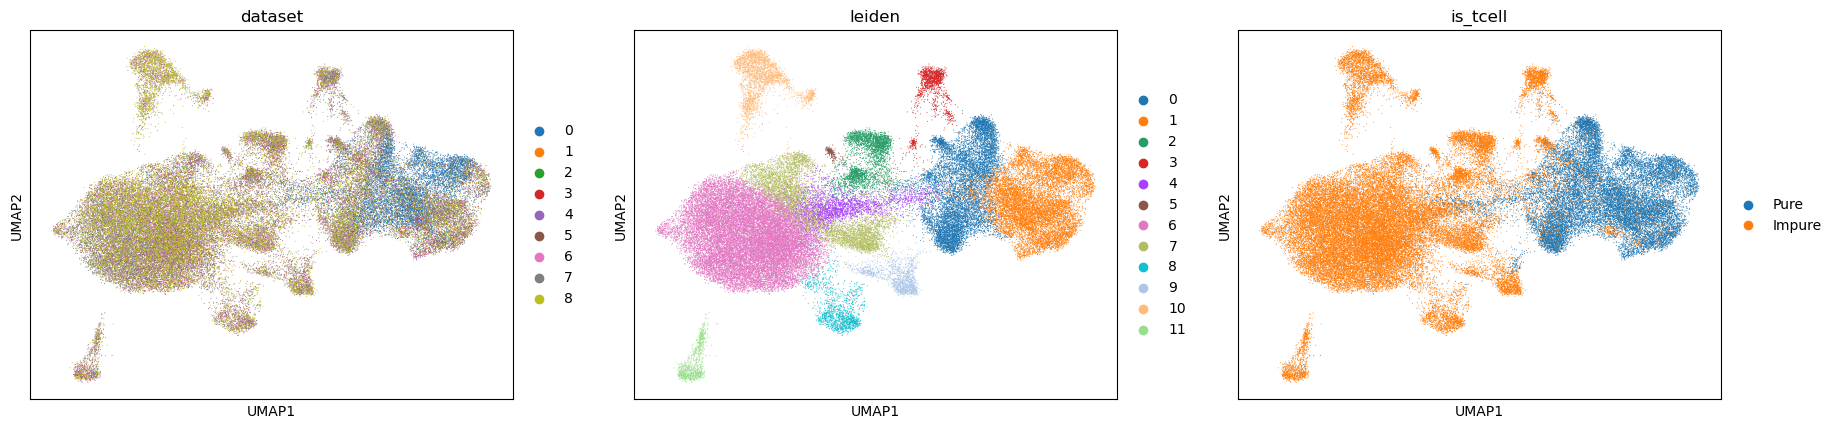

In [68]:
adata_merged_hvg.X = adata_merged_hvg.layers['integrated_scanpy']
sc.tl.pca(adata_merged_hvg)
sc.pp.neighbors(adata_merged_hvg)
sc.tl.umap(adata_merged_hvg)
sc.tl.leiden(adata_merged_hvg, resolution=0.4, flavor="igraph" , n_iterations=2)
sc.pl.umap(adata_merged_hvg, color=['dataset', 'leiden', 'is_tcell'])

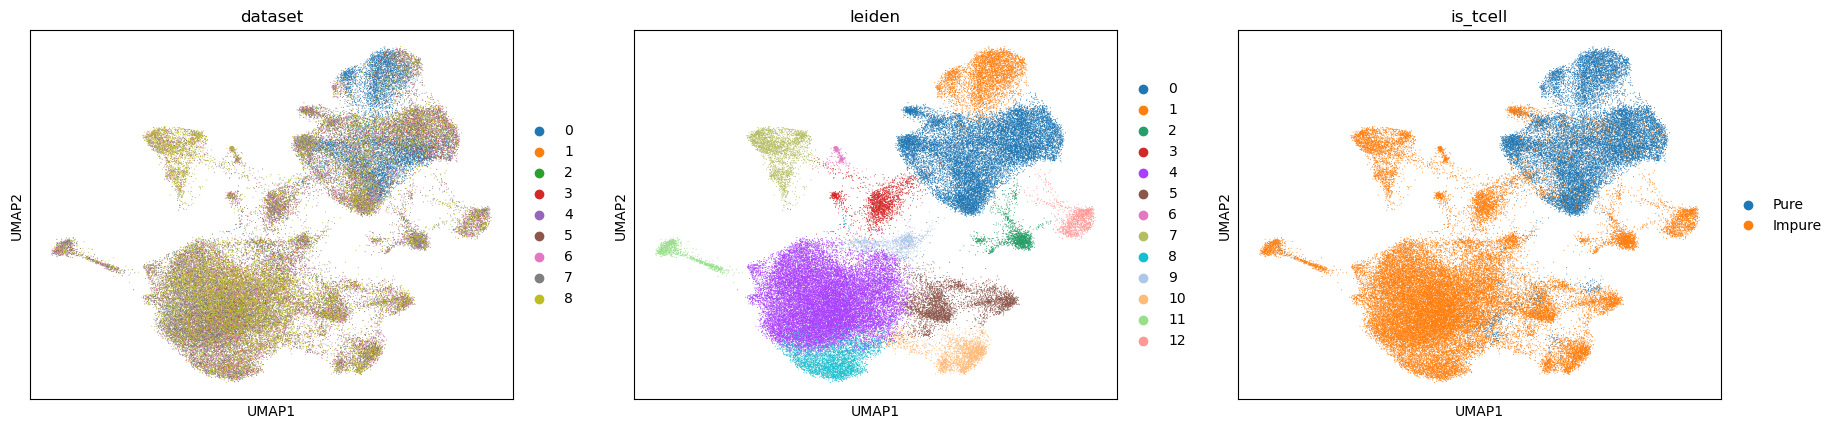

In [67]:
# adata_merged_hvg.X = adata_merged_hvg.layers['integrated_seurat']
# sc.tl.pca(adata_merged_hvg)
# sc.pp.neighbors(adata_merged_hvg)
# sc.tl.umap(adata_merged_hvg)
# sc.tl.leiden(adata_merged_hvg, resolution=0.4, flavor="igraph" , n_iterations=2)
sc.pl.umap(adata_merged_hvg, color=['dataset', 'leiden', 'is_tcell'])

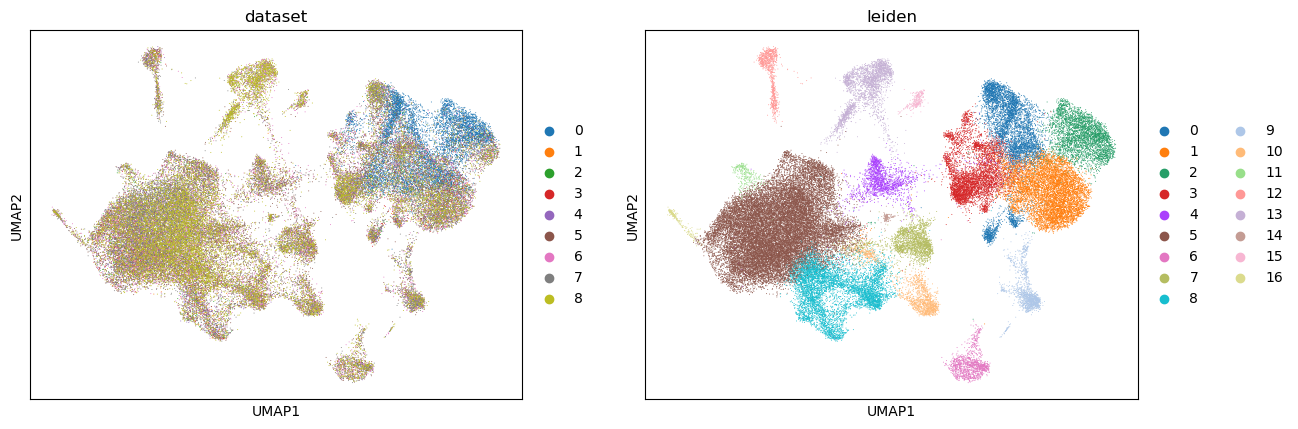

In [90]:
sc.pl.umap(adata_merged_hvg, color=['dataset', 'leiden'])

### 10. Perform Celltype annotation

In [54]:
#using scGate, this is based on the seurat object 'integrated' generated before by stacas. If you are using the integrated matrix from python, you will need to specify the new seurat object and remove reduction = "pca" so that scGate itself generates the pca reduction itself
%R sc_gating_models <- get_scGateDB()
%R seurat_object_annotated <- scGate(integrated, model = sc_gating_models$mouse$generic$Tcell, ncores = 4, reduction = "pca", output.col.name = "is.tcell") #, reduction = 'calculate', assay = 'originalexp'
%R annotation <- seurat_object_annotated@meta.data$is.tcell
%R -o annotation

adata_merged.obs['is_tcell'] = annotation
sum(adata_merged.obs.is_tcell == 'Pure')

  |======================================================================| 100%

  |======================================================================| 100%



19520

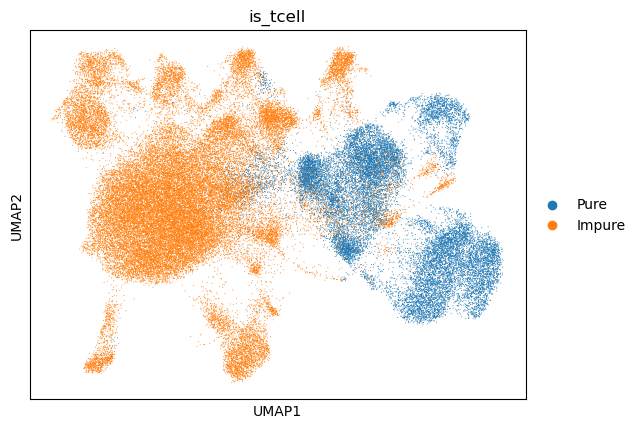

In [55]:
sc.tl.pca(adata_merged)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)
sc.pl.umap(adata_merged, color='is_tcell')

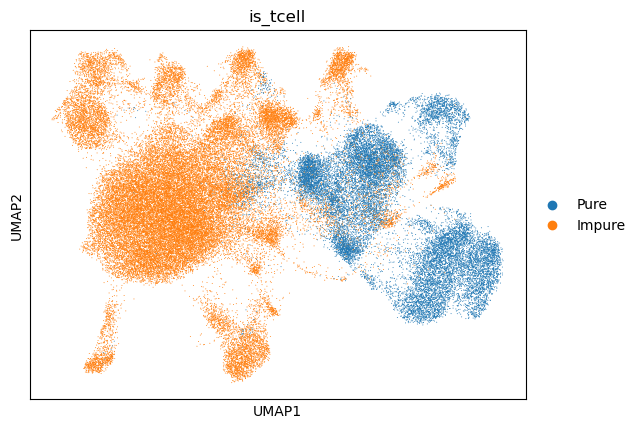

In [51]:
sc.tl.pca(adata_merged)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)
sc.pl.umap(adata_merged, color='is_tcell')

### 11. Save the progress

In [ ]:
adata_merged.write('01_data/processed/qc/merged_qc_abs.h5ad', compression='gzip') #takes forever 